In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Face Rank

数学与统计学院 

江金阳 2017301000090 周睿涵 2018302010038

作业训练的是一个迷你的VGG网络，用来给人的颜值打分，颜值越高分数越高（0-9分）。由于数据集质量的原因目前的训练结果时而不尽人意，但整个代码框架和思路已经基本上完善好了，如有必要我可再重新制作数据集训练或添加其他功能。

这个项目中我使用的训练集、验证集和测试集中没有相同的样本，模型可以对没有见过的面孔打分。从预测的情况来看，由于训练集普遍是笑的正面登记照，尽管我用拉伸变形进行了数据增强，模型仍然对表情或光照有一定的敏感性，或许以后在这个问题上我应该考虑选择用脸的特征点来做，而不是直接用图像来做。


**分工明细:**

| **Chapter** | **Jiang Jinyang** | **Zhou Ruihan** |
|:--------|:--------|:--------|
|0 打印硬件信息|  |$\checkmark$|
|1 重置数据文件夹|  |$\checkmark$|
|2 准备数据集|  |$\checkmark$|
|3 生成数据集|$\checkmark$|$\checkmark$|
|4 定义神经网络|$\checkmark$|  |
|5 参数管理|  |$\checkmark$|
|6 训练过程|$\checkmark$|  |
|7 测试过程|$\checkmark$|  |
|8 静态颜值预测|$\checkmark$|$\checkmark$|
|9 动态颜值预测|$\checkmark$|  |

**说明:**

上述0、1、2、8、9项可以单独运行，运行3-7时建议顺序运行

**项目所有依赖如下:**

In [1]:
# 项目的所有依赖项，若顺序运行可不执行本窗口
import shutil
import torch
import os
import xlrd
from PIL import Image
import face_recognition
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import cv2
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets
from tensorboardX import SummaryWriter

# 仅用于爬虫的依赖项
from bs4 import BeautifulSoup
import urllib.request
import requests
import time
import json
import sys
import re

# 0 打印硬件信息

In [25]:
import torch

print(f'Num of GPU: {torch.cuda.device_count()}')
print(f'Cuda is available: {torch.cuda.is_available()}')
print(f'Working device: {torch.device("cuda:0" if torch.cuda.is_available() else "cpu")}')
print(f'GPU info: {torch.cuda.get_device_name(0)}')

Num of GPU: 1
Cuda is available: True
Working device: cuda:0
GPU info: GeForce GTX 1050 Ti


# 1 重置数据文件夹

清除所有工作文件夹内数据

In [1]:
import shutil

In [2]:
shutil.rmtree('./original_train_set')
shutil.copytree('./reset/original_train_set','./original_train_set')

'./original_train_set'

In [3]:
shutil.rmtree('./original_test_set')
shutil.copytree('./reset/original_test_set','./original_test_set')

'./original_test_set'

In [4]:
shutil.rmtree('./face_train_set')
shutil.copytree('./reset/face_train_set','./face_train_set')

'./face_train_set'

In [5]:
shutil.rmtree('./face_test_set')
shutil.copytree('./reset/face_test_set','./face_test_set')

'./face_test_set'

# 2 准备数据集

In [7]:
import os
import xlrd
import shutil
from PIL import Image
import face_recognition
from tqdm.notebook import tqdm

from bs4 import BeautifulSoup
import urllib.request
import requests
import time
import json
import sys
import re

## 2.1 从SCUT-FBP5500_v2导入数据

SCUT-FBP5500_v2是华南理工大学人机交互智能实验室2017年制作的数据集，其中包含亚洲、欧美男女性脸部图片及对应打分，命名规则为亚洲男性（AM）、亚洲女性（AF）、欧美男性（CM）、欧美女性（CF），本项目暂时只使用了其中女性的数据

In [8]:
def score2rank(score):
    '''
    tansform real score to discrete ranks
    '''
    standard = [2.2,
                2.416667,
                2.583333,
                2.7,
                2.833333,
                3.016667,
                3.316667,
                3.7,
                4.033333,
               ]
    if score <= standard[0]:
        return 0
    elif score > standard[0] and score <= standard[1]:
        return 1
    elif score > standard[1] and score <= standard[2]:
        return 2
    elif score > standard[2] and score <= standard[3]:
        return 3
    elif score > standard[3] and score <= standard[4]:
        return 4
    elif score > standard[4] and score <= standard[5]:
        return 5
    elif score > standard[5] and score <= standard[6]:
        return 6
    elif score > standard[6] and score <= standard[7]:
        return 7
    elif score > standard[7] and score <= standard[8]:
        return 8
    elif score > standard[8]:
        return 9

In [9]:
data = xlrd.open_workbook('./train.xlsx')
table = data.sheets()[0]
nrows = table.nrows

print('Generating original train set:')
for i in tqdm(range(nrows)):
    image_name, score = table.row_values(i)
    if 'F' in image_name:
        srcpath = './original_set/' + image_name
        dstpath = './original_train_set/'+ str(score2rank(score)) + '/' + image_name        
        shutil.copy(srcpath, dstpath)
    
data = xlrd.open_workbook('./test.xlsx')
table = data.sheets()[0]
nrows = table.nrows

print('Generating original test set:')
for i in tqdm(range(nrows)):
    image_name, score = table.row_values(i)
    if 'F' in image_name:
        srcpath = './original_set/' + image_name
        dstpath = './original_test_set/'+ str(score2rank(score)) + '/' + image_name        
        shutil.copy(srcpath, dstpath)

Generating original train set:



Generating original test set:


<img style="float: center;" src="./jupyter_image/dataprepare0.png" width="60%"> 

## 2.2 用爬虫补充数据集

从SCUT-FBP5500_v2数据集获取的数据并不一定符合我们当前的审美标准，本段允许用户根据自己的喜好添加数据

In [42]:
#爬取目标网站url
CRAWL_TARGET_URL = 'https://cn.bing.com/images/async?q=%s&first=%d&count=%d&relp=%d&lostate=r&mmasync=1'
#每次抓取图片数量(35是此网页每次翻页请求数量)
NUMS_PER_CRAWL = 35
#抓取图片最小大小(单位字节)，小于此值抛弃
MIN_IMAGE_SIZE = 10

def get_image(url, path, count):
    try:
        u = urllib.request.urlopen(url, timeout=5)
        t = u.read()
        if sys.getsizeof(t) < MIN_IMAGE_SIZE:
            return -1
    except Exception as e:
        #print(url, e)
        return -2
    #提取图片格式
    frmt = url[url.rfind('.'):]
    p = re.compile("^\\.[a-zA-Z]+")
    m = p.match(frmt)
    frmt = m.group(0)
    try:
        if not os.path.exists(path):
            os.mkdir(path)
        f = open(os.path.join(path, str(count)+frmt), 'wb')
        f.write(t)
        f.close()
    except Exception as e:
        #print(os.path.join(path, str(count)+frmt), e)
        return -3
    return 0


def crawl_data(info, num, save_path):
    first = 0
    count = 0
    #创建一个会话
    s = requests.Session()
    index=len(os.listdir(save_path))#文件中原有图片数
    while count < num:
        u = CRAWL_TARGET_URL%(info, first, NUMS_PER_CRAWL, NUMS_PER_CRAWL)
        #3.05s为发送超时时间，10s为接收到数据超时时间
        req = s.get(url =u, timeout=(3.05, 10))
        bf = BeautifulSoup(req.text, "html.parser")
        imgtags = bf.find_all("a", class_ = "iusc")
        for e in imgtags:
            if count == num:
                return False
            urldict = json.loads(e.get('m'))
            if get_image(urldict["murl"], save_path, index) < 0:
                continue
            print("Downloaded %d picture"%(count+1))
            sys.stdout.flush()
            count = count+1
            index = index+1
            time.sleep(0.01)
        first = first + NUMS_PER_CRAWL
        time.sleep(0.1)
    return True

In [38]:
# key_words中每条包含：爬取的关键词，爬取数量，用户对这类图片的给分
key_words=[['黑猩猩',10,'0'],
           ['抖音 美女',10,'7'],
           ['最美面孔 女 亚洲',10,'9'],
           ['亚洲最美10大女明星',10,'9'],
          ]

for i in range(len(key_words)):
    info = key_words[i][0]
    num = key_words[i][1]
    rank =  key_words[i][2]
    save_path = './original_train_set/' + rank
    print(f'Downloading label: {info} Rank: {rank}')
    if crawl_data(info, num, save_path):
        i = i+1

Downloaded 1 picture
Downloaded 2 picture
Downloaded 3 picture
Downloaded 4 picture
Downloaded 5 picture
Downloaded 6 picture
Downloaded 7 picture
Downloaded 8 picture
Downloaded 9 picture
Downloaded 10 picture
Downloaded 1 picture
Downloaded 2 picture
Downloaded 3 picture
Downloaded 4 picture
Downloaded 5 picture
Downloaded 6 picture
Downloaded 7 picture
Downloaded 8 picture
Downloaded 9 picture
Downloaded 10 picture
Downloaded 1 picture
Downloaded 2 picture
Downloaded 3 picture
Downloaded 4 picture
Downloaded 5 picture
Downloaded 6 picture
Downloaded 7 picture
Downloaded 8 picture
Downloaded 9 picture
Downloaded 10 picture
Downloaded 1 picture
Downloaded 2 picture
Downloaded 3 picture
Downloaded 4 picture
Downloaded 5 picture
Downloaded 6 picture
Downloaded 7 picture
Downloaded 8 picture
Downloaded 9 picture
Downloaded 10 picture


<img style="float: center;" src="./jupyter_image/dataprepare1.png" width="60%"> 

## 2.3 捕获人脸并统一图片尺寸

使用face_recognition库中的face_locations接口获取图片中人脸上下左右的指标范围，再截取人脸并变换成统一尺寸，在本文中，图片尺寸被统一为 $128\times128\times3$

In [47]:
def find_and_resize_face(original,face):
    # Load the jpg file into a numpy array
    image = face_recognition.load_image_file(original)
    # Find all the faces in the image
    face_locations = face_recognition.face_locations(image)
    for face_location in face_locations:
        top, right, bottom, left = face_location
        face_image = image[top:bottom, left:right]
        pil_image = Image.fromarray(face_image)
        pil_image = pil_image.resize((128, 128))
        pil_image.save(face)

In [48]:
print('Generating face train set:')            
folder_list = os.listdir('./original_train_set')
for folder in tqdm(folder_list):
    image_list = os.listdir('./original_train_set/' + folder)
    for image in image_list:
        id_tag = image.find(".") # 之所以写这一步是为了避免出现非.jpg后缀的图片文件
        image_name = image[0:id_tag]
        original = './original_train_set/' + folder + '/' + image
        face =  './face_train_set/' + folder + '/' + image_name + '.jpg'
        try:
            find_and_resize_face(original,face)
        except:
            print("fail")

print('Generating face test set:')
folder_list = os.listdir('./original_test_set')
for folder in tqdm(folder_list):
    image_list = os.listdir('./original_test_set/' + folder)
    for image in image_list:
        id_tag = image.find(".")
        image_name = image[0:id_tag]
        original = './original_test_set/' + folder + '/' + image
        face =  './face_test_set/' + folder + '/' + image_name + '.jpg'
        try:
            find_and_resize_face(original,face)
        except:
            print("fail")

Generating face train set:



Generating face test set:


<img style="float: center;" src="./jupyter_image/dataprepare2.png" width="60%"> 

# 3 生成数据集

torchvision.datasets.ImageFolder是一个通用的数据加载器,允许用户制作一个类似CIFAR10的数据集，并通过DataLoader使用它

我们将训练集、验证集的生成封装成了函数get_train_valid_loader，将测试集的生成封装成了函数get_test_loader，他们分别返回两个和一个DataLoader

In [50]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms, datasets

# 3.1 生成训练集和验证集

训练集和验证集从原始训练集图片文件夹生成，按一定比例（valid_ratio）划分为训练集和验证集

由于我们不便于收集比较大的数据集，样本规模在$10^4$个以下，训练时容易发生数据量引发的过拟合，因此在训练集上进行了数据增强，对图片以一定的概率水平翻转、旋转、仿射变换，在多轮训练中，相当于将数据集扩大了若干倍

In [51]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           valid_ratio=0.1,
                           shuffle=True,
                           num_workers=4,
                           pin_memory=False):

    # dataset augmentation for train_set
    random_choice = transforms.RandomChoice([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomAffine(degrees=0, shear=(10,10)),
        ])
    
    transform_train = transforms.Compose([
        transforms.RandomApply([random_choice], p=0.6),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    
    # transform for valid_set
    transform_valid = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    # load the dataset
    train_set = datasets.ImageFolder(root=data_dir, transform=transform_train)
    valid_set = datasets.ImageFolder(root=data_dir, transform=transform_valid)

    num_train = len(train_set)
    indices = list(range(num_train))
    split = int(np.floor(valid_ratio * num_train))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
        
    train_idx, valid_idx = indices[split:], indices[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, 
        sampler=train_sampler, num_workers=num_workers
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_set, batch_size=batch_size, 
        sampler=valid_sampler, num_workers=num_workers
    )
    return (train_loader, valid_loader)

## 3.2 生成测试集

In [52]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=True,
                    num_workers=2):
    
    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.ImageFolder(root=data_dir, transform=transform)

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, 
        shuffle=shuffle, num_workers=num_workers
    )

    return data_loader

## 3.3 测试DataLoaders

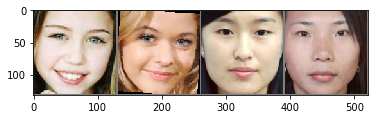

    8     9     5     1


In [53]:
train_loader, valid_loader = get_train_valid_loader('./face_train_set/',
                                                    batch_size = 4,
                                                    random_seed = 123,
                                                    valid_ratio = 0.1,
                                                    shuffle = True)

test_loader = get_test_loader('./face_test_set/',
                              batch_size=4,
                              shuffle=True)

classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')
    
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
img = torchvision.utils.make_grid(images) / 2 + 0.5 # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
    
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# 4 定义神经网络: MiniVGG

VGG的优点：

1.小卷积核，将卷积核全部替换为3x3（极少用了1x1）

2.小池化核，相比AlexNet的3x3的池化核，VGG全部为2x2的池化核

3.层数更深特征图更宽，基于前两点外，由于卷积核专注于扩大通道数、池化专注于缩小宽和高，使得模型架构上更深更宽的同时，计算量的增加放缓；

| **Layer Type** | &nbsp; &nbsp; &nbsp;**Output Size**&nbsp; &nbsp; &nbsp; | **Filter Size/Stride** |
|:--------| :-----------|:--------|
| INPUT IMAGE | $128 \times 128 \times 3$ |  |
| CONV | $128 \times 128 \times 32$ | $3 \times 3, K = 32$ |
| ACT | $128 \times 128 \times 32$ |  |
| GN | $128 \times 128 \times 32$ |  |
| CONV | $128 \times 128 \times 32$ | $3 \times 3, K = 32$ |
| ACT | $128 \times 128 \times 32$ |  |
| GN | $128 \times 128 \times 32$ |  |
| POOL | $64 \times 64 \times 32$ | $2 \times 2$ |
| DROPOUT | $64 \times 64 \times 32$ |  |
| CONV | $64 \times 64 \times 64$ | $3 \times 3, K = 64$ |
| ACT | $64 \times 64 \times 64$ |  |
| GN | $64 \times 64 \times 64$ |  |
| CONV | $64 \times 64 \times 64$ | $3 \times 3, K = 64$ |
| ACT | $64 \times 64 \times 64$ |  |
| GN | $64 \times 64 \times 64$ |  |
| POOL | $32 \times 32 \times 64$ | $2 \times 2$ |
| DROPOUT | $32 \times 32 \times 64$ |  |
| FC | $1024$ |  |
| ACT | $1024$ |  |
| GN | $1024$ |  |
| DROPOUT | $1024$ |  |
| FC | $256$ |  |
| ACT | $256$ |  |
| GN | $256$ |  |
| DROPOUT | $256$ |  |
| FC | $10$ |  |
| SOFTMAX | $10$ |  |

In [54]:
import torch
import torch.nn as nn

In [55]:
def activation(name):
    '''
    Activation function switcher
    '''
    if name.upper() == 'TANH':
        return nn.Tanh()
    elif name.upper() == 'RELU':
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name.upper() == 'SIGMOID':
        return nn.Sigmoid()
    elif name.upper() == 'SOFTPLUS':
        return nn.Softplus()
    else: 
        raise ValueError(f'Unknown activation function: {name}')

In [56]:
class ConvBlock(nn.Sequential):
    '''
    Convolutional Block
    '''
    def __init__(self, in_channels, out_channels, pool=True, act_name = 'relu',drop_rate=0.):
        super().__init__()
        self.add_module('conv', nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True))
        self.add_module('act', activation(act_name))
        self.add_module('norm', nn.GroupNorm(4,out_channels))
        if pool:
            self.add_module('pool', nn.MaxPool2d(kernel_size=2))
        if drop_rate > 0:
            self.add_module('dropout', nn.Dropout(p=drop_rate)) 

In [57]:
class FcBlock(nn.Sequential):
    '''
    Fully Connected Block
    '''
    def __init__(self, dim_in, dim_out, act_name = 'relu', drop_rate=0.):
        super().__init__()
        self.add_module('fc', nn.Linear(dim_in, dim_out, bias = True))
        self.add_module('act', activation(act_name))
        self.add_module('norm', nn.GroupNorm(4,dim_out))
        if drop_rate > 0:
            self.add_module('dropout', nn.Dropout(p=drop_rate))

In [58]:
class Net(nn.Module):
    def __init__(self, act_name = 'relu', init_name = 'kaiming_normal', drop_rate = 0.):
        super(Net, self).__init__()
        model = nn.Sequential()
        model.add_module('conv_block1', ConvBlock(3,  32, pool=False))
        model.add_module('conv_block2', ConvBlock(32, 32, pool=True,  drop_rate=drop_rate))
        model.add_module('conv_block3', ConvBlock(32, 64, pool=False))
        model.add_module('conv_block4', ConvBlock(64, 64, pool=True, drop_rate=drop_rate))
        model.add_module('flatten',nn.Flatten(start_dim=1, end_dim=-1))
        model.add_module('fc_block1', FcBlock(64*32*32, 1024, drop_rate=drop_rate))
        model.add_module('fc_block2',FcBlock(1024, 256 ,drop_rate = drop_rate))
        model.add_module('last_layer', nn.Linear(256, 10, bias = True))        
        self.model = model
        
        if init_name is not None:
            self.init_weight(init_name)
            
    def forward(self, x):
        return self.model(x)
            
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params 

### 网络结构可视化

In [59]:
from tensorboardX import SummaryWriter

dummy_input = torch.rand(1,3,128,128)
model = Net()

with SummaryWriter(comment='Net') as w:
    w.add_graph(model,(dummy_input,))# 在同目录下生成runs文件夹
    # 在含有runs的目录下使用命令行：tensorboard --logdir runs
    # 用浏览器打开生成的xxxx6006地址即可

<img style="float: center;" src="./jupyter_image/tensorboard.png" width="60%"> 

### 打印网络结构

In [82]:
model = Net()
print(model)
print(f'num of params: {model.model_size()}')

x = torch.randn(2,3,128,128)
y = model(x)
print(f'input shape: {x.shape}, output shape: {y.shape}')

Net(
  (model): Sequential(
    (conv_block1): ConvBlock(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
    )
    (conv_block2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (norm): GroupNorm(4, 32, eps=1e-05, affine=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv_block3): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
    )
    (conv_block4): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (act): ReLU(inplace=True)
      (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

# 5 参数管理

使用argparse库创建args对象，对参数集中管理

In [62]:
import argparse

class Options(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--batch_size', type=int, default=8, help='batchsize for dataloader')
        parser.add_argument('--info_print', type=int, default=25, help='when to print loss info')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--dropout', type=float, default=0.75, help='dropout rate')
        parser.add_argument('--act_name', type=str, default='relu', help='activation function')
        parser.add_argument('--init_name', type=str, default='kaiming_normal', help='weight initiate method')
        parser.add_argument('--epochs_Adam', type=int, default=10, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=2, help='epochs for LBFGS optimizer')
        self.parser = parser
        
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return arg

# 6 训练过程

In [63]:
import os 
import shutil
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

In [64]:
def save_model(state, is_best=None, save_dir=None):
    '''
    save last model and best model
    '''
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [65]:
class Trainer(object):
    def __init__(self, args):
        self.device  = args.device
        print(f'Working device: {self.device}')
                
        self.info_print = args.info_print
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.criterion = nn.CrossEntropyLoss()
                
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), max_iter=20, tolerance_grad=1.e-8, tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, step_size=args.step_size, gamma=args.gamma)
        self.train_loader = args.train_loader
        self.valid_loader = args.valid_loader
        
        self.model.to(self.device)
        self.model.zero_grad()
    
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
    
        return path

    def infos_Adam(self, epoch, batch, loss):
        infos = 'Adam  ' + \
            f'Epoch # {epoch+1:3d}//{self.epochs_Adam+self.epochs_LBFGS} Batch: {batch+1:3d} ' + \
            f'Loss: {loss:.4e} ' + f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def infos_LBFGS(self, epoch, batch, loss):
        infos = 'LBFGS ' + \
            f'Epoch # {epoch+1:3d}//{self.epochs_Adam+self.epochs_LBFGS} Batch: {batch+1:3d} ' + \
            f'Loss: {loss:.2e}'
        print(infos)

    def valid(self, epoch, batch):
        self.model.eval()
        valid_loss = 0.0
        count = 0
        for i, data in enumerate(self.valid_loader):
            inputs, labels = data
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            valid_loss += loss.item()
            count = count+1
        valid_loss = valid_loss/count
        infos = 'Valid ' + \
            f'Epoch # {epoch+1:3d}//{self.epochs_Adam+self.epochs_LBFGS} Batch: {batch+1:3d} ' + \
            f'Loss: {valid_loss:.4e} '
        print(infos)
        return valid_loss
        
    def train(self):
        print('Start training ...')
        
        train_losses_index = []
        train_losses = []
        valid_losses_index = []
        valid_losses = []
        curve_index = 0
        best_loss = 1.e10
        
        for epoch in range(self.epochs_Adam):
            running_loss = 0.0
            for batch, data in enumerate(self.train_loader):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)           
                self.optimizer_Adam.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer_Adam.step()
                self.lr_scheduler.step()
                running_loss += loss.item()
                if (batch+1) % self.info_print == 0:
                    running_loss = running_loss / self.info_print
                    self.infos_Adam(epoch, batch, running_loss)                    
                    train_losses_index += [curve_index]
                    train_losses += [running_loss]
                    running_loss = 0.0   

                    valid_loss = self.valid(epoch, batch)
                    is_best = valid_loss < best_loss
                    best_loss = valid_loss if is_best else best_loss
                    state = {'epoch': epoch, 
                            'state_dict': self.model.state_dict(),
                            'best_loss': best_loss}
                    save_model(state, is_best, save_dir=self.model_path)
                    valid_losses_index += [curve_index]
                    valid_losses += [valid_loss]
                curve_index = curve_index + 1
                
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            running_loss = 0.0
            for batch, data in enumerate(self.train_loader):
                inputs, labels = data
                inputs, labels = inputs.to(self.device), labels.to(self.device)  
                def closure():
                    if torch.is_grad_enabled():
                        self.optimizer_LBFGS.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    if loss.requires_grad:
                        loss.backward()
                    return loss
                self.optimizer_LBFGS.step(closure)
                loss = closure()
                running_loss += loss.item()
                if (batch+1) % self.info_print == 0:
                    running_loss = running_loss / self.info_print
                    self.infos_LBFGS(epoch, batch, running_loss)
                    train_losses_index += [curve_index]
                    train_losses += [running_loss]
                    running_loss = 0.0   
                    
                    valid_loss = self.valid(epoch, batch)
                    is_best = valid_loss < best_loss
                    best_loss = valid_loss if is_best else best_loss
                    state = {'epoch': epoch, 
                            'state_dict': self.model.state_dict(),
                            'best_loss': best_loss}
                    save_model(state, is_best, save_dir=self.model_path)
                    valid_losses_index += [curve_index]
                    valid_losses += [valid_loss]
                curve_index = curve_index + 1         
                
        print('Finished training ...')
        # save loss curve info
        np.save('loss.npy',[train_losses_index,train_losses,valid_losses_index,valid_losses])

In [ ]:
args = Options().parse()
args.model = Net(drop_rate = args.dropout, act_name = args.act_name)
args.train_loader, args.valid_loader = get_train_valid_loader('./face_train_set/',
                                                              batch_size = args.batch_size,
                                                              random_seed = 123,
                                                              valid_ratio = 0.1,
                                                              shuffle = True,)

trainer = Trainer(args)
trainer.train()

### 绘制Loss曲线

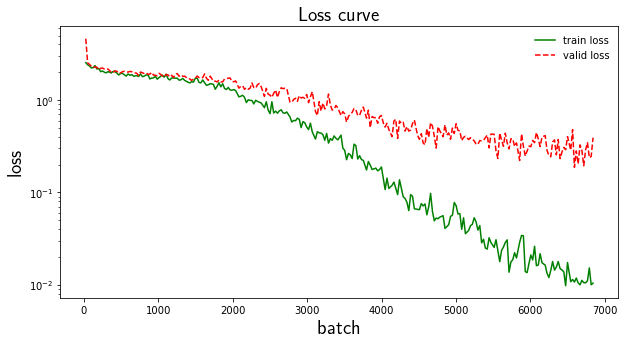

In [85]:
# load data
loss_data = np.load('loss.npy',allow_pickle=True)
train_losses_index = loss_data[0]
train_losses = loss_data[1]
valid_losses_index = loss_data[2]
valid_losses = loss_data[3]

# loss curve
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.set_title('Loss curve',usetex = True,fontsize=20)
ax.set_yscale("log")
ax.set_xlabel('batch',usetex = True,fontsize=20)
ax.set_ylabel('loss',usetex = True,fontsize=20)
ax.plot(train_losses_index, train_losses, color = 'g', label = 'train loss')
ax.plot(valid_losses_index, valid_losses, color = 'r', linestyle='--', label = 'valid loss')
ax.legend(frameon=False, loc = 'best')
plt.savefig('Loss_curve')
plt.show()

# 7 测试过程

## 7.1 测试模型在测试集上的整体表现

In [29]:
class Tester(object):
    def __init__(self, args):
        self.device  = args.device
        print(f'Working device: {self.device}')
        
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.test_loader = args.test_loader        
        
    def test(self):
        self.model.eval()

        correct = 0
        total = 0

        class_correct = list(0. for i in range(10))
        class_total = list(0. for i in range(10))

        with torch.no_grad():
            for data in self.test_loader:
                images, labels = data
                images, labels = images.to(self.device), labels.to(self.device)

                outputs = self.model(images)
                _, predicted = torch.max(outputs, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                c = (predicted == labels).squeeze()
                for i in range(4):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1
        
        classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')
        print('Accuracy of the network on test images: %d %%' % (100 * correct / total))
        for i in range(10):
            try:
                print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
            except:
                print('There is no test image scoring %5s' % classes[i])

PS：这个结果对应的模型被我不小心覆盖掉了

In [32]:
args = Options().parse()
args.model = Net(drop_rate = args.dropout, act_name = args.act_name)
args.test_loader = get_test_loader('./face_test_set/',
                                   batch_size=8,
                                   shuffle=False,
                                   num_workers=2)

tester = Tester(args)
tester.test()

Working device: cuda
Accuracy of the network on test images: 92 %
Accuracy of     0 : 95 %
Accuracy of     1 : 94 %
Accuracy of     2 : 90 %
Accuracy of     3 : 85 %
Accuracy of     4 : 89 %
Accuracy of     5 : 90 %
Accuracy of     6 : 90 %
Accuracy of     7 : 96 %
Accuracy of     8 : 89 %
Accuracy of     9 : 97 %


## 7.2 测试模型在随机一个batch上的表现

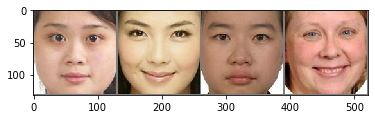

GroundTruth:      2     9     2     0
Predicted:      2     9     2     0


In [34]:
# load model
model = Net()
model_name = model.__class__.__name__
model_path = os.path.join('checkpoints',model_name,'best_model.pth.tar')
best_model = torch.load(model_path)
model.load_state_dict(best_model['state_dict'])        
model.eval()

classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

# initial dataloader
test_loader = get_test_loader('./face_test_set/',
                              batch_size=4,
                              shuffle=True,
                              num_workers=2)
# define transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

dataiter = iter(test_loader)
images, labels = dataiter.next()

# show images
img = torchvision.utils.make_grid(images) / 2 + 0.5 # unnormalize
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

# GroundTruth
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] 
                               for j in range(4)))
# Predicted
outputs = model(images)
_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] 
                              for j in range(4)))

# 8 静态颜值预测

可直接从此处开始运行

In [18]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms, datasets
from my_net import Net

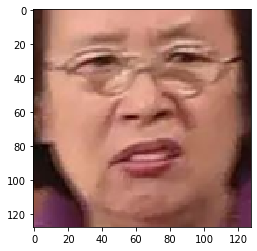

Predicted:      0


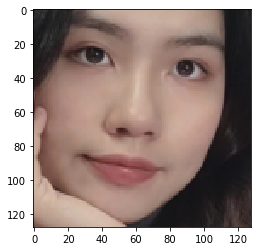

Predicted:      6


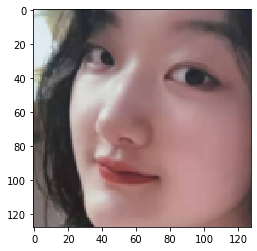

Predicted:      7


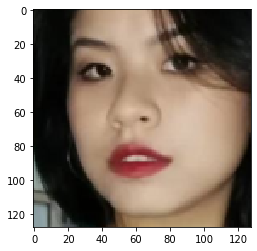

Predicted:      8


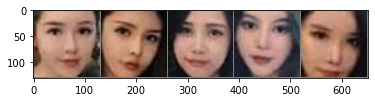

Predicted:      7     9     7     8     8


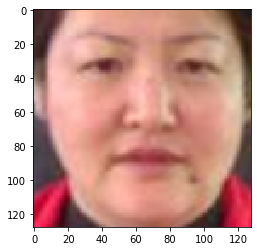

Predicted:      1


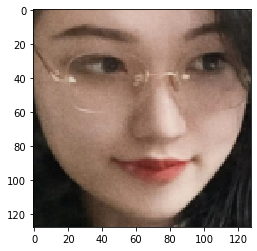

Predicted:      9


In [19]:
classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

model = Net()
model_name = model.__class__.__name__
model_path = os.path.join('checkpoints',model_name,'best_model.pth.tar')
best_model = torch.load(model_path)
model.load_state_dict(best_model['state_dict'])        
model.eval()
    
image_list = os.listdir('./predict_set')

transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

for image_name in image_list:
    image = face_recognition.load_image_file('./predict_set/'+image_name)
    face_locations = face_recognition.face_locations(image)
    image_container = torch.empty(len(face_locations),3,128,128)
    for index,face_location in enumerate(face_locations):
        top, right, bottom, left = face_location
        image_container[index] = transform(Image.fromarray(image[top:bottom, left:right]))

    # show images
    img = torchvision.utils.make_grid(image_container) / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
    # Predicted
    outputs = model(image_container)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(len(face_locations))))

<img style="float: center;" src="./jupyter_image/predicting.png" width="60%"> 

# 9 实时颜值预测

可直接从此处开始运行

**Step1**: 使用OpenCV库获取帧

**Step2**: 使用face_recognition库获取人脸

**Step3**: 使用torchvision.transform进行与前面相同的预处理

**Step4**: 使用训练好的模型进行预测

**Step5**: 使用OpenCV将训练结果打在帧上并显示

In [11]:
import face_recognition
import cv2
import os
import torch
from PIL import Image
from torchvision import transforms, datasets
from my_net import Net

In [12]:
# define transforms
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

classes = ('0','1', '2', '3', '4', '5', '6', '7', '8', '9')

# load model
model = Net()
model_name = model.__class__.__name__
model_path = os.path.join('checkpoints',model_name,'best_model.pth.tar')
best_model = torch.load(model_path)
model.load_state_dict(best_model['state_dict'])        
model.eval()

# camera prepare
video_capture = cv2.VideoCapture(0)
process_this_frame = True
while True:
    # get a frame from camera
    ret, frame = video_capture.read()
    try:
        # resize the frame to speed up the process
        small_frame = cv2.resize(frame, (0, 0), fx=0.25, fy=0.25)
        # transform to RGB image
        rgb_frame = small_frame[:,:,::-1]
        if process_this_frame:
            face_locations = face_recognition.face_locations(rgb_frame)
            face_container = torch.empty(len(face_locations),3,128,128)
            for index,face_location in enumerate(face_locations):
                top, right, bottom, left = face_location
                face_container[index] = transform(Image.fromarray(rgb_frame[top:bottom, left:right]))
            # predict face rank
            outputs = model(face_container)
            _, face_ranks = torch.max(outputs, 1)
        process_this_frame = not process_this_frame
        # show the face ranks on the screen
        for (top, right, bottom, left), rank in zip(face_locations, face_ranks):
            top = top * 4
            right = right * 4
            bottom = bottom * 4
            left = left * 4
            cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255),  2)
            cv2.rectangle(frame, (left, bottom - 35), (right, bottom), (0, 0, 255), 2)
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, 'Rank:'+ classes[rank], (left+6, bottom-6), font, 1.0, (255, 255, 255), 1)
    except:
        # in case that no face is captured
        pass
    cv2.imshow('Video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        # press 'q' to close the window
        break

video_capture.release()
cv2.destroyAllWindows()